In [1]:
# helper
from graphviz import Digraph

def _trace(root):
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)))

    return dot

In [2]:
import numpy as np
from numbers import Real

class Value():
    def __init__(self, data, operation="", children=()):
        if isinstance(data, (list, tuple, Real)):
            data = np.array(data)
        assert isinstance(data, np.ndarray), "data must be a numpy array"
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = np.zeros_like(self.data, dtype=float)
        self._backward = lambda: None

    def __repr__(self):
        return str(self.data)
    
    def dot(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert self.data.ndim == 1 and other.data.ndim == 1, "Dot product is only defined for vectors"
        result = Value(np.dot(self.data, other.data), "•", (self, other))
        def _backward():
            self.grad += np.dot(result.grad, other.data)
            other.grad += np.dot(result.grad, self.data)
        result._backward = _backward
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, "+", (self, other))
        def _backward():
            self.grad += result.grad
            other.grad += result.grad
        result._backward = _backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert not self.data.shape or not other.data.shape, "Multiplication is undefined for two non-scalar values"
        result = Value(self.data * other.data, "*", (self, other))
        def _backward():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "power must be float or integer" # must force "other" to be primitive float or int
        assert other >= 0, "power must be non-negative"
        result = Value(self.data ** other, "^", (self,))
        def _backward():
            self.grad += other * self.data ** (other - 1) * result.grad
        result._backward = _backward
        return result
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return self - other
    
    def __rmul__(self, other):
        return self * other
    
    def __rtruediv__(self, other):
        return self / other
    
    def backward(self):
        # A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.
        # We need this, since we must call backward() on a child strictly after it has been called on its parent
        nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                nodes.append(v)
        build_topo(self)
        self.grad = np.ones(self.data.shape)
        for node in reversed(nodes):
            node._backward()

    def zero_grad(self):
        self.grad = np.zeros_like(self.data, dtype=float)
        for child in self.children:
            assert isinstance(child, Value), "Child must be an instance of Value"
            child.zero_grad()
    

In [3]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = 0.2 * e

loss.backward()

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

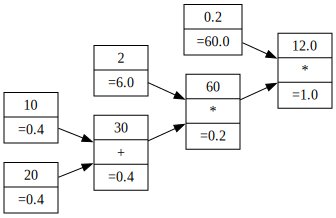

In [4]:
dot = draw_dot(loss)
dot

119.99469589159301 1.0
[ 9.43606798 11.73205081] [6.5 5. ]
[2.23606798 1.73205081] [6.5 5. ]
[5 3] [1.45344419 1.44337567]
[6.5 5. ] [ 9.43606798 11.73205081]
[ 7.2 10. ] [6.5 5. ]


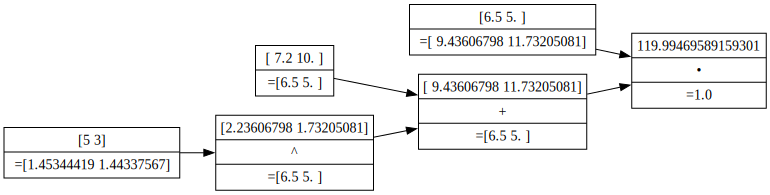

In [5]:
a = Value([5, 3])
b = Value([6.5, 5])
c = Value([7.2, 10])
d = a **0.5
e = d + c
loss = e.dot(b)

loss.backward()

print(loss.data, loss.grad)
print(e.data, e.grad)
print(d.data, d.grad)
print(a.data, a.grad)
print(b.data, b.grad)
print(c.data, c.grad)


dot = draw_dot(loss)
dot